In [1]:
import pandas as pd

df = pd.read_csv('Datacamp CSV/YuruCamp_Reviews.csv', index_col = 0)

# No, it worked! It was just some guy who wrote literally the exact same review
# Current problem is that we have too few reviews on MAL, and too many words. 
# Try using a stemmer to help reduce number of words. UPDATE: Looks like it still doesn't
# really work. That's unfortunate, but at least you can see what words are associated with a
# positive Naruto review!

# Categorise the reviews by positive or negative. Positive if 7+, Negative if 6-
df['verdict'] = np.where(df['score'] > 6, 'positive', 'negative')
df['helpful'] = df['helpful'].astype(int)
df['score'] = df['score'].astype(int)
df.sort_values(['helpful'], ascending = False)

,date,seen,score,helpful,review,verdict
50,"Mar 22, 2018",12 of 12 episodes seen,9,274,"“¡ One for all, hole in one!” —Nadeshiko Kaga...",positive
51,"Mar 22, 2018",12 of 12 episodes seen,6,157,Another edition to the endlessly growing rost...,negative
52,"Mar 22, 2018",12 of 12 episodes seen,8,114,"I think that sometimes, to relax, we need to ...",positive
53,"Mar 22, 2018",12 of 12 episodes seen,8,56,The sun is setting. The cold breezes that bru...,positive
54,"Jan 26, 2018",4 of 12 episodes seen,9,47,"Sit back, relax, and gaze upon the glory that...",positive
...,...,...,...,...,...,...
7,"Aug 21, 2020",12 of 12 episodes seen,9,0,My soul has been purified by this show. I wan...,positive
6,"Oct 18, 2020",12 of 12 episodes seen,9,0,"First I want to say: ""I love this anime"". Thi...",positive
5,"Nov 14, 2020",12 of 12 episodes seen,6,0,"It's a bit overrated. Not *bad*, but overrate...",negative
4,"Jan 6, 2021",1 of 12 episodes seen,10,0,I watch literally one episode and I'm so comf...,positive


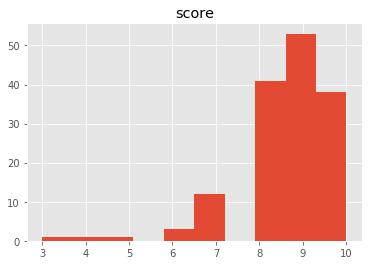

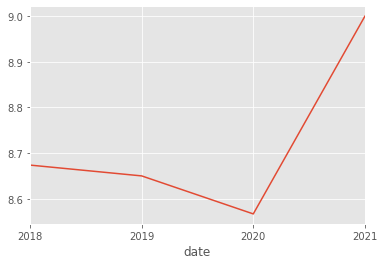

In [3]:
# Some preliminary EDA
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Distribution of Naruto scores
df.hist('score', bins = 10)
plt.show()

# Naruto scores over time
df['date'] = pd.to_datetime(df['date'])

df.set_index('date').resample('Y')['score'].mean().plot()
plt.show()

In [10]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

porter = PorterStemmer()

# Stemming doesn't work on sentences - a stemmer will think the entire sentence is a word
# We need to read in the sentence, tokenize it, then stem it.
def stemSentence(sentence):
    # Tokenize the sentence
    token_words=word_tokenize(sentence)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in token_words if not w in stop_words]
    
    # Stem each word and reform the document.
    stem_sentence=[]
    for word in filtered_sentence:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# Let's stem each review and do the machine learning again
df['stemmed_review'] = df['review'].apply(stemSentence)

df

,date,seen,score,helpful,review,verdict,stemmed_review
0,2018-11-22,12 of 12 episodes seen,8,1,"If we talk about a slice of life anime, espec...",positive,"If talk slice life anim , especi ’ relat iyash..."
1,2018-10-26,12 of 12 episodes seen,8,1,Rin Shima is a regular off-season camper who ...,positive,rin shima regular off-season camper enjoy quie...
2,2018-05-26,12 of 12 episodes seen,9,1,***SHORT REVIEW*** Are u the type who loves ...,positive,***short review*** are u type love explor love...
3,2018-03-24,12 of 12 episodes seen,9,1,When the Winter Season started I did not have...,positive,when winter season start I high hope I expect ...
4,2021-01-06,1 of 12 episodes seen,10,0,I watch literally one episode and I'm so comf...,positive,I watch liter one episod I 'm comfort I fall a...
...,...,...,...,...,...,...,...
145,2018-04-01,12 of 12 episodes seen,8,3,This series is one of the many Slice of Life ...,positive,thi seri one mani slice life ( sol ) seri emer...
146,2018-03-29,12 of 12 episodes seen,9,3,Warmth. Is the word I choose if I were to de...,positive,warmth . Is word I choos I describ show one wo...
147,2018-03-25,12 of 12 episodes seen,10,3,Story - 7 I'm giving Yuru Camp a 7 for story...,positive,stori - 7 I 'm give yuru camp 7 stori 's exact...
148,2018-03-24,12 of 12 episodes seen,9,3,"COMFY: The Anime Yuru Camp, a show about cam...",positive,"comfi : the anim yuru camp , show camp watch c..."


In [16]:
# Get our features and target variable
X = df['review']
y = df['verdict']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                    test_size = 0.1, 
                                                    random_state = 123)

# Note that this gets only alphabets, NOT numbers.
alphanumeric = '[A-Za-z]+(?=\\s+)'

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2

# Create our pipeline. 
pipeline = Pipeline([('vectorizer', CountVectorizer(token_pattern = alphanumeric, 
                                                    stop_words = 'english', 
                                                    ngram_range = (1,2))), 
                     ('transformer', TfidfTransformer()),
                     ('classifier', LogisticRegression(C = 10, solver = 'newton-cg'))
                    ])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='[A-Za-z]+(?=\\s+)',
                                 tokenizer=None, voc...
                ('transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sc

In [101]:
from sklearn.model_selection import GridSearchCV

params = {
    'classifier__C': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001],
    'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg']
}

search = GridSearchCV(pipeline, params, cv = 3, scoring='neg_log_loss', verbose = 1, n_jobs = -1)
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    9.3s finished


{'classifier__C': 10.0, 'classifier__solver': 'newton-cg'}
-0.4894896325826042


In [103]:
predictions = pipeline.score(X_test, y_test)
predictions

0.775

In [17]:
# Get the vocabulary found in the reviews.
vocab = pipeline['vectorizer'].get_feature_names()

# This finds out what the coeffients used to fit the model are, from the most negative to
# most positive.
# Each coefficient used to help predict. A positive helps predict the positive class, etc.
coefs = pipeline['classifier'].coef_.flatten()
inds_ascending = np.argsort(coefs) 
inds_descending = inds_ascending[::-1]

print("Most positive words: ", end="")
for i in range(21):
    print(vocab[inds_descending[i]], end=", ")
print("\n")

print("Most negative words: ", end="")
for i in range(1, 21):
    print(vocab[inds_ascending[i]], end=", ")
print("\n")

Most positive words: anime, nadeshiko, art, camp, yuru camp, watching, camping, main, fun, want, simple, different, sound, perfect, beautiful, recommend, amazing, outdoor, actually, watch, m, 

Most negative words: incredibly, t, series, s, pretty, conflict, things like, failed, s really, dimensional, cool, camaraderie, okay, manga, ways, defined, anime liked, animation pretty, opinion s, bore, 



In [27]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Collect all the positive reviews
positive_reviews = " ".join(review for review in df[df['score'] > 7]['review'])

stop_words = set(stopwords.words('english'))
stop_words.update(["anime", "show", "character", "characters"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, 
                      background_color="white",
                     width=800, height=400).generate(positive_reviews)

%matplotlib qt
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()